# Deployment and Testing

In [2]:
# Import packages 
from __future__ import print_function, division

import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()   # interactive mode

## Deploy Model 

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"
data_bucket = 'cap2-ngandn18'
bucket = sagemaker_session.default_bucket()

# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
datapath = 'data'
print(sagemaker_session, bucket, region, datapath)

<sagemaker.session.Session object at 0x7fb930ecd590> sagemaker-us-east-1-503563512855 us-east-1 data


In [4]:
# Deploy your model to an endpoint
training_job_name = 'pytorch-training-2022-01-19-11-46-10-633'
print(f'training_job_name = {training_job_name}')

training_job_name = pytorch-training-2022-01-19-11-46-10-633


In [5]:
bucket = sagemaker_session.default_bucket()
model_name = 's3://{}/{}/output/model.tar.gz'.format(bucket,training_job_name)
print(model_name)

s3://sagemaker-us-east-1-503563512855/pytorch-training-2022-01-19-11-46-10-633/output/model.tar.gz


In [6]:
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

model_name = 's3://{}/{}/output/model.tar.gz'.format(bucket,training_job_name)

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

fn_model = PyTorchModel(model_data=model_name, 
                         role=role,
                         entry_point='inference.py',
                         py_version='py38',
                         framework_version='1.9',
                         predictor_cls=ImagePredictor
                        )

In [30]:
#### Important
from time import time
since = time()
fn_predictor = fn_model.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge"
    ) 
print(f'Time deploy: {time() - since} s')

endpoint_name = fn_predictor.endpoint_name
print(endpoint_name)
# pytorch-inference-2021-12-13-20-31-24-675

------!Time deploy: 190.0153739452362 s
pytorch-inference-2022-01-20-14-02-40-688


In [31]:
print(f'endpoint_name = {endpoint_name}')

endpoint_name = pytorch-inference-2022-01-20-14-02-40-688


### Predicting

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
import random
from time import time

In [18]:
# Get test image info
testset = pd.read_csv('test.csv')
labels = list(testset['label'])
fullnames = list(testset['fullname'])

In [19]:
testset['label'].value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

In [20]:
# Get label~classid and filename randomly
def get_file_classid():
    row = random.randint(0, len(testset)-1)
    return labels[row], fullnames[row] 
    # ldic[row].values()
print(get_file_classid())

(0, 'data/test/0/jumbo_jet_s_000306.png')


In [21]:
# Check the result
classid, filename = get_file_classid()
with open(filename, "rb") as f:
    payload = f.read()
len(payload)

2896

In [33]:
# Predict one test file 
from sagemaker.serializers import IdentitySerializer
with open(filename, "rb") as f:
    payload = f.read()
    
since = time()
fn_predictor.serializer = IdentitySerializer("image/jpeg")
inference = fn_predictor.predict(payload)
print(f'Time Prediction: {time() - since} s')

Time Prediction: 0.17029905319213867 s


In [34]:
print(type(inference[0]),'\n',len(inference[0]), '\n', inference[0])
prediction = np.argmax(inference)
if prediction == classid:
    print('Prediction is correct')
else:
    print('Prediction is not correct')
print(prediction, filename, classid)

<class 'list'> 
 10 
 [5.852695465087891, -3.7856357097625732, 2.849529504776001, 1.3429663181304932, 1.5686414241790771, -1.5139240026474, -1.9197814464569092, -1.5171016454696655, 2.1233861446380615, -1.7676165103912354]
Prediction is not correct
0 data/test/2/gamecock_s_000228.png 7


In [35]:
# Test 100-image prediction
since = time()
infers = []
files = []
classes = []
preds = []
count = 0
nums = 100
for k in range(nums):
    classid, filename = get_file_classid()
    classes.append(classid)
    files.append(filename)
    with open(filename, "rb") as f:
        payload = f.read()
    
    inference = fn_predictor.predict(payload)
    infers.append(inference[0])
    prediction = np.argmax(inference[0])
    preds.append(prediction)
    if prediction == classid:
        count = count + 1

print(f'Time {nums} Prediction: {time() - since: .02f} s')
accu = count / nums
print(f'Accuracy of {nums} predictions: {accu: .04f} = {accu*100: .0f}%')

Time 100 Prediction:  12.43 s
Accuracy of 100 predictions:  0.8500 =  85%


### Prediction of all test images

In [37]:
import random
from time import time

since = time()
infers = []
preds = []
count = 0
nums = len(fullnames)

for k in range(nums):
    filename = fullnames[k]
    with open(filename, "rb") as f:
        payload = f.read()
    
    inference = fn_predictor.predict(payload)
    infers.append(inference[0])
    prediction = np.argmax(inference[0])
    # Save prediction fro reuse later    
    preds.append(prediction)
        
print(f'Time {nums} Prediction: {time() - since: .01f} s')

Time 10000 Prediction:  1155.7 s


In [39]:
df_prediction = pd.DataFrame({'label': labels,'pred': preds})

N = len(labels)
equal_inds = df_prediction['label'] == df_prediction['pred']
nums = sum(equal_inds)
accu = nums / N
print(f'Accuracy of all test directory predictions: {accu: .04f} = {accu*100: .0f}%')
df_prediction.to_csv('prediction.csv', index=False)

Accuracy of all test directory predictions:  0.8035 =  80%


In [40]:
with open ('preds3.txt', 'w') as f:
    f.write(str(preds))
with open ('infers3.txt', 'w') as f:
    f.write(str(infers))

In [46]:
equal_inds = df_prediction['label'] == df_prediction['pred']
nums = sum(equal_inds)
accuracy = nums / N
accuracy

0.8035

In [47]:
df_equal = df_prediction['label'][equal_inds]
df_equal.reset_index(drop=True, inplace=True)
print(type(df_equal.value_counts()), '\n',df_equal.value_counts())
# Prepare data for calculating each class accuracy
classes = {}
for j in range(len(df_equal)):
    k = df_equal[j]
    if k not in classes.keys():
        classes[k] = 1
    else:
        classes[k] += 1
        
print(classes)

<class 'pandas.core.series.Series'> 
 8    965
0    928
3    903
4    870
2    826
1    788
7    741
6    735
9    694
5    585
Name: label, dtype: int64
{3: 903, 8: 965, 0: 928, 6: 735, 1: 788, 9: 694, 5: 585, 7: 741, 4: 870, 2: 826}


In [32]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
# fn_predictor.delete_endpoint()
### Finish

In [29]:
CLS_LENGTH = 1000
cls_ratio = []
for k in range(10):
    cls_ratio.append(classes[k]/CLS_LENGTH)
    print(f'Accuracy of class {k}: {cls_ratio[k]: 0.4f} ~{100*cls_ratio[k]: 0.0f}%')

Accuracy of class 0:  0.9280 ~ 93%
Accuracy of class 1:  0.7880 ~ 79%
Accuracy of class 2:  0.8260 ~ 83%
Accuracy of class 3:  0.9030 ~ 90%
Accuracy of class 4:  0.8700 ~ 87%
Accuracy of class 5:  0.5850 ~ 58%
Accuracy of class 6:  0.7350 ~ 74%
Accuracy of class 7:  0.7410 ~ 74%
Accuracy of class 8:  0.9650 ~ 96%
Accuracy of class 9:  0.6940 ~ 69%


In [10]:
cls_names = pd.read_csv('classes.csv')
cls_names

,class_id,class_name
0,0,airplane
1,1,automobile
2,2,bird
3,3,cat
4,4,deer
5,5,dog
6,6,frog
7,7,horse
8,8,ship
9,9,truck


In [23]:
for k in range(10):
    cls_ratio.append(classes[k]/CLS_LENGTH)
    print(f'Accuracy of class {cls_names["class_name"][k]}:{cls_ratio[k]: 0.4f} ~ \t{100*cls_ratio[k]: 0.0f}%')

Accuracy of class airplane: 0.9280 ~ 	 93%
Accuracy of class automobile: 0.7880 ~ 	 79%
Accuracy of class bird: 0.8260 ~ 	 83%
Accuracy of class cat: 0.9030 ~ 	 90%
Accuracy of class deer: 0.8700 ~ 	 87%
Accuracy of class dog: 0.5850 ~ 	 58%
Accuracy of class frog: 0.7350 ~ 	 74%
Accuracy of class horse: 0.7410 ~ 	 74%
Accuracy of class ship: 0.9650 ~ 	 96%
Accuracy of class truck: 0.6940 ~ 	 69%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

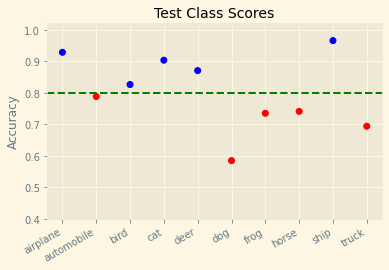

In [35]:
# Plot the data
x,y = list(cls_names['class_name']), cls_ratio
plt.scatter(x, y, c=['r' if k<.80 else 'b' for k in y ])
plt.axhline(y=0.80, color='g', linestyle='--')
plt.ylim(bottom=.4,top=1.02)

# Add labels
plt.ylabel("Accuracy")
# plt.suptitle("Bogo Test Scores", size=14)
plt.title("Test Class Scores", size=14)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
fn_predictor.delete_endpoint()
### Finish